# Machine Learning Exercise

Now it's time to practice what you have seen in the previous notebooks. Your task for today is to download the data from the database and train a model in order to predict if a patient has a heart disease or not. 

![](https://www.nicepng.com/png/detail/397-3975460_disease-high-quality-png-heart-disease-cartoon-png.png)

## Task:

1. Import the data from the database. The schema is called `heart`. You can use DBeaver to get an overview over the different tables and think about a good way to join them. 
2. Conduct a brief EDA to become familiar with the data. 
3. Preprocess the data as far as you need it and...
4. ...train a logistic regression model.

## What you should use/keep in mind:
 
* **Scale your data:** Which scaler works best in your case?
* **Tune your model:** Tune the hyperparameter of your model. You can start with a larger parameter grid and a `RandomizedSearchCV` and continue with a narrower parameter grid for your `GridSearchCV`.
* **Choose the right evaluation metric!**


## Data Overview

| column | additional information |
|--------|------------------------|
| age | age of patient |
| sex | gender of patient |
| chest_pain_type  | 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic | 
| resting_blood_pressure |  | 
| fasting_blood_sugar | > 120 mg/dl, 1 = true, 0 = false | 
| thal | 0 = normal, 1 = fixed defect, 2 = reversable defect
| serum_cholestoral | in mg/dl | 
| resting_electrocardiographic_results | 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria | 
| maximum_heartrate_achieved | | 
| exercise_induced_angina | 1 = yes, 0 = no | 
| oldpeak | ST depression induced by exercise relative to rest | 
| slope_of_the_peak_exercise_st_segment | 1= upsloping, 2 = flat, 3 = downsloping | 
| number_of_major_vessels_colored_by_flourosopy | |
| real_data | tag to distinguish between real and made up data | 
| heart_attack | 0 = little risk of heart attack, 1 = high risk of heart attack | 

## Import

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feel free to add all the libraries you need

## Getting the Data

The data for this exercise is stored in our postgres database in the schema `heart`. The different features are split thematically into five different tables. Your first task will be to have a look at the tables (e.g. in DBeaver) and figure out a way to join the information you need. As soon as you're happy with your query, you can use the following code cells to import the data into this notebook. 

In previous notebooks you've seen two different approaches to import data from a database into a notebook. The following code will use `sqlalchemy`in combination with pandas `pd.read_sql()` function. For the code to work, you need to copy the `.env` file from the previous repositories into this repository and change the query_string to your own query.

In [2]:
# Read database string from .env file (no need to change anything)
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [3]:
# Define query to download data (add your query here)
query_string = """
                SET SCHEMA 'heart';
                SELECT *
                FROM heart.patient AS p
                LEFT JOIN heart.pressure_vessels_angina AS pva ON pva.patient_id = p.id
                LEFT JOIN heart.chest_pain AS cp ON cp.patient_id = p.id
                LEFT JOIN heart.heart_attack_history AS hah ON hah.patient_id = p.id
                LEFT JOIN heart.blood_metrics AS bm ON bm.patient_id = p.id
                WHERE pva.real_data <> 'Evgeny likes white wine for lunch and red wine for dinner'
                OR pva.real_data IS NULL
                ORDER BY p.id ASC;"""

# Import with pandas
df_sqlalchemy = pd.read_sql(query_string, db)
df_sqlalchemy.head()

,id,age,sex,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,...,patient_id,id,heart_attack,patient_id,id,serum_cholestoral,fasting_blood_sugar,thal,patient_id,id
0,0,63.0,1.0,145.0,0.0,150.0,0.0,2.3,0.0,0.0,...,0.0,1.0,1,0,1,233.0,1.0,1.0,0.0,1.0
1,1,NaN,1.0,130.0,1.0,187.0,0.0,3.5,0.0,0.0,...,1.0,2.0,1,1,2,250.0,0.0,2.0,1.0,2.0
2,2,41.0,0.0,130.0,0.0,172.0,0.0,1.4,2.0,0.0,...,2.0,3.0,1,2,3,204.0,0.0,2.0,2.0,3.0
3,3,56.0,1.0,120.0,1.0,178.0,0.0,0.8,2.0,0.0,...,3.0,4.0,1,3,4,236.0,0.0,2.0,3.0,4.0
4,4,57.0,0.0,120.0,1.0,163.0,1.0,0.6,2.0,0.0,...,4.0,5.0,1,4,5,354.0,0.0,2.0,4.0,5.0


In [4]:
# Save dataframe as .csv file
df_sqlalchemy.to_csv("heart_data.csv", index=False)

In [5]:
df = pd.read_csv("heart_data.csv")

In [6]:
df.head()

,id,age,sex,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,...,patient_id.1,id.2,heart_attack,patient_id.2,id.3,serum_cholestoral,fasting_blood_sugar,thal,patient_id.3,id.4
0,0,63.0,1.0,145.0,0.0,150.0,0.0,2.3,0.0,0.0,...,0.0,1.0,1,0,1,233.0,1.0,1.0,0.0,1.0
1,1,NaN,1.0,130.0,1.0,187.0,0.0,3.5,0.0,0.0,...,1.0,2.0,1,1,2,250.0,0.0,2.0,1.0,2.0
2,2,41.0,0.0,130.0,0.0,172.0,0.0,1.4,2.0,0.0,...,2.0,3.0,1,2,3,204.0,0.0,2.0,2.0,3.0
3,3,56.0,1.0,120.0,1.0,178.0,0.0,0.8,2.0,0.0,...,3.0,4.0,1,3,4,236.0,0.0,2.0,3.0,4.0
4,4,57.0,0.0,120.0,1.0,163.0,1.0,0.6,2.0,0.0,...,4.0,5.0,1,4,5,354.0,0.0,2.0,4.0,5.0


In [7]:
df.columns

Index(['id', 'age', 'sex', 'resting_blood_pressure',
       'resting_electrocardiographic_results', 'maximum_heartrate_achieved',
       'exercise_induced_angina', 'oldpeak',
       'slope_of_the_peak_exercise_st_segment',
       'number_of_major_vessels_colored_by_flourosopy', 'patient_id', 'id.1',
       'real_data', 'chest_pain_type', 'patient_id.1', 'id.2', 'heart_attack',
       'patient_id.2', 'id.3', 'serum_cholestoral', 'fasting_blood_sugar',
       'thal', 'patient_id.3', 'id.4'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   id                                             353 non-null    int64  
 1   age                                            343 non-null    float64
 2   sex                                            334 non-null    float64
 3   resting_blood_pressure                         303 non-null    float64
 4   resting_electrocardiographic_results           303 non-null    float64
 5   maximum_heartrate_achieved                     292 non-null    float64
 6   exercise_induced_angina                        303 non-null    float64
 7   oldpeak                                        303 non-null    float64
 8   slope_of_the_peak_exercise_st_segment          303 non-null    float64
 9   number_of_major_vessels_colored_by_flourosopy  303 non

In [9]:
df.isnull().sum()

id                                                 0
age                                               10
sex                                               19
resting_blood_pressure                            50
resting_electrocardiographic_results              50
maximum_heartrate_achieved                        61
exercise_induced_angina                           50
oldpeak                                           50
slope_of_the_peak_exercise_st_segment             50
number_of_major_vessels_colored_by_flourosopy     50
patient_id                                        50
id.1                                              50
real_data                                        110
chest_pain_type                                   50
patient_id.1                                      50
id.2                                              50
heart_attack                                       0
patient_id.2                                       0
id.3                                          

In [10]:
df.shape

(353, 24)

In [11]:
df = df.drop(['patient_id', 'id.1','patient_id.1', 'id.2','patient_id.2', 'id.3', 'patient_id.3', 'id.4'], axis = 1)

In [12]:
df.head()

,id,age,sex,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,real_data,chest_pain_type,heart_attack,serum_cholestoral,fasting_blood_sugar,thal
0,0,63.0,1.0,145.0,0.0,150.0,0.0,2.3,0.0,0.0,real data,3.0,1,233.0,1.0,1.0
1,1,NaN,1.0,130.0,1.0,187.0,0.0,3.5,0.0,0.0,real data,2.0,1,250.0,0.0,2.0
2,2,41.0,0.0,130.0,0.0,172.0,0.0,1.4,2.0,0.0,real data,1.0,1,204.0,0.0,2.0
3,3,56.0,1.0,120.0,1.0,178.0,0.0,0.8,2.0,0.0,real data,1.0,1,236.0,0.0,2.0
4,4,57.0,0.0,120.0,1.0,163.0,1.0,0.6,2.0,0.0,NaN,0.0,1,354.0,0.0,2.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   id                                             353 non-null    int64  
 1   age                                            343 non-null    float64
 2   sex                                            334 non-null    float64
 3   resting_blood_pressure                         303 non-null    float64
 4   resting_electrocardiographic_results           303 non-null    float64
 5   maximum_heartrate_achieved                     292 non-null    float64
 6   exercise_induced_angina                        303 non-null    float64
 7   oldpeak                                        303 non-null    float64
 8   slope_of_the_peak_exercise_st_segment          303 non-null    float64
 9   number_of_major_vessels_colored_by_flourosopy  303 non

In [14]:
df.isnull().sum()

id                                                 0
age                                               10
sex                                               19
resting_blood_pressure                            50
resting_electrocardiographic_results              50
maximum_heartrate_achieved                        61
exercise_induced_angina                           50
oldpeak                                           50
slope_of_the_peak_exercise_st_segment             50
number_of_major_vessels_colored_by_flourosopy     50
real_data                                        110
chest_pain_type                                   50
heart_attack                                       0
serum_cholestoral                                 50
fasting_blood_sugar                               50
thal                                              50
dtype: int64

In [15]:
numerical_columns = df.select_dtypes(include="number").columns

In [16]:
numerical_columns

Index(['id', 'age', 'sex', 'resting_blood_pressure',
       'resting_electrocardiographic_results', 'maximum_heartrate_achieved',
       'exercise_induced_angina', 'oldpeak',
       'slope_of_the_peak_exercise_st_segment',
       'number_of_major_vessels_colored_by_flourosopy', 'chest_pain_type',
       'heart_attack', 'serum_cholestoral', 'fasting_blood_sugar', 'thal'],
      dtype='object')

In [17]:
df[numerical_columns].corr()

,id,age,sex,resting_blood_pressure,resting_electrocardiographic_results,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,chest_pain_type,heart_attack,serum_cholestoral,fasting_blood_sugar,thal
id,1.000000,0.154218,0.122340,0.108507,-0.021130,-0.403762,0.363788,0.298161,-0.276484,0.384962,-0.399163,-0.624380,0.020258,0.000743,0.257403
age,0.154218,1.000000,-0.075011,0.277101,-0.117288,-0.391658,0.076699,0.220841,-0.177875,0.283520,-0.053604,-0.071919,0.227735,0.128711,0.056197
sex,0.122340,-0.075011,1.000000,-0.065777,-0.050907,-0.040984,0.154686,0.094660,-0.025554,0.122691,-0.055476,-0.261438,-0.198438,0.028124,0.205599
resting_blood_pressure,0.108507,0.277101,-0.065777,1.000000,-0.114103,-0.041708,0.067616,0.193216,-0.121475,0.101389,0.047608,-0.144931,0.123174,0.177531,0.062210
resting_electrocardiographic_results,-0.021130,-0.117288,-0.050907,-0.114103,1.000000,0.047653,-0.070733,-0.058770,0.093045,-0.072042,0.044421,0.137230,-0.151040,-0.084189,-0.011981
maximum_heartrate_achieved,-0.403762,-0.391658,-0.040984,-0.041708,0.047653,1.000000,-0.375942,-0.346881,0.400348,-0.215799,0.296817,0.421899,-0.013405,-0.006183,-0.083213
exercise_induced_angina,0.363788,0.076699,0.154686,0.067616,-0.070733,-0.375942,1.000000,0.288223,-0.257748,0.115739,-0.394280,-0.436757,0.067023,0.025665,0.206754
oldpeak,0.298161,0.220841,0.094660,0.193216,-0.058770,-0.346881,0.288223,1.000000,-0.577537,0.222682,-0.149230,-0.430696,0.053952,0.005747,0.210244
slope_of_the_peak_exercise_st_segment,-0.276484,-0.177875,-0.025554,-0.121475,0.093045,0.400348,-0.257748,-0.577537,1.000000,-0.080155,0.119717,0.345877,-0.004038,-0.059894,-0.104764
number_of_major_vessels_colored_by_flourosopy,0.384962,0.283520,0.122691,0.101389,-0.072042,-0.215799,0.115739,0.222682,-0.080155,1.000000,-0.181053,-0.391724,0.070511,0.137979,0.151832


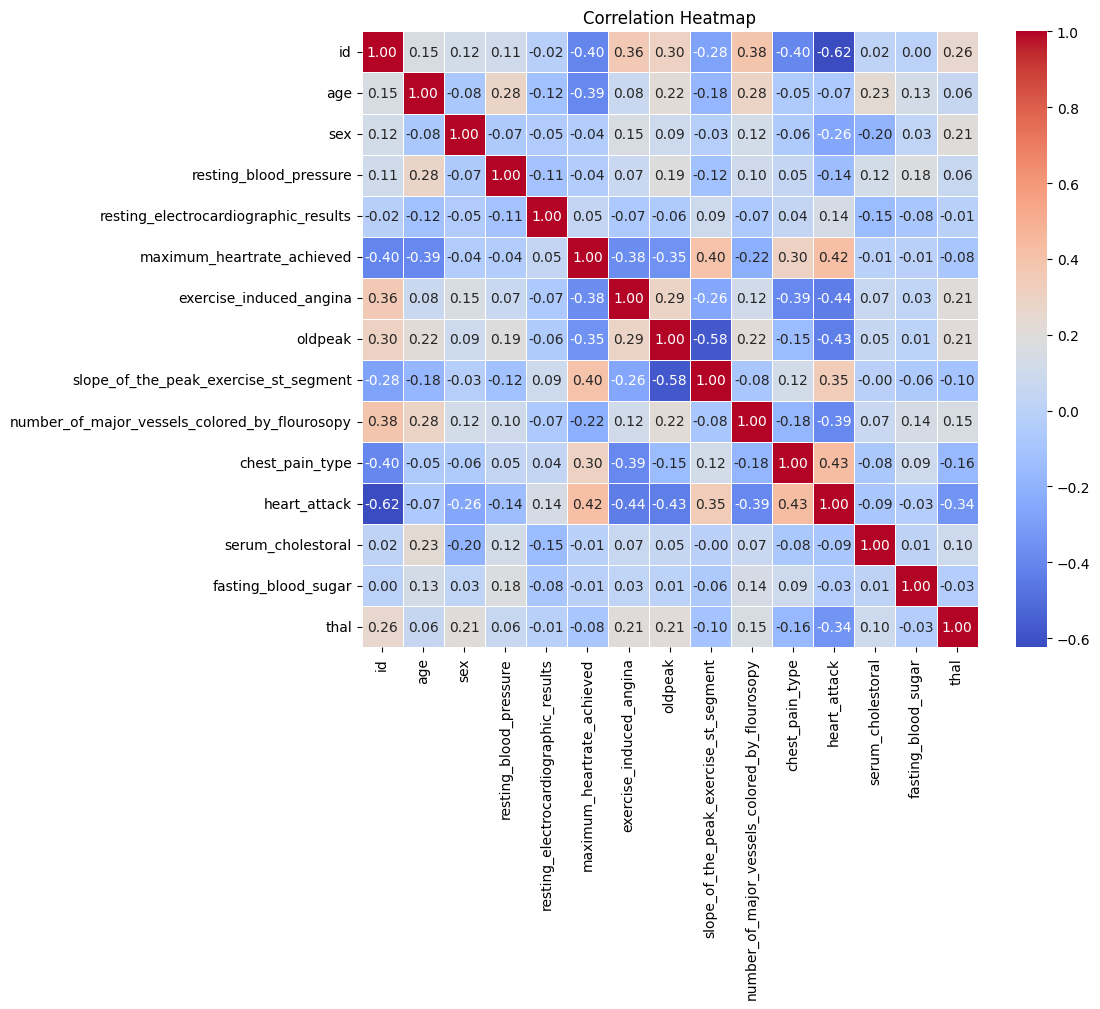

In [18]:
import seaborn as sns

corr = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()

<Axes: >

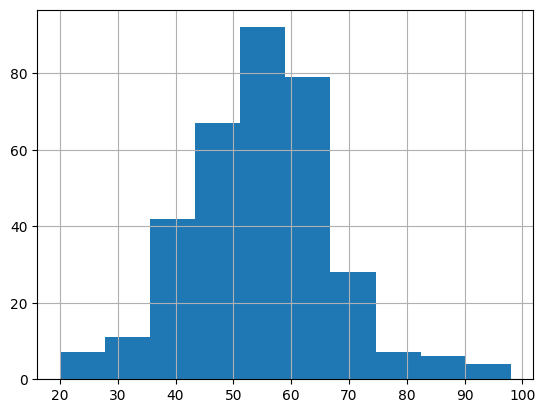

In [19]:
df['age'].hist()

In [20]:
df.groupby('sex')['heart_attack'].sum()

sex
0.0     78
1.0    104
Name: heart_attack, dtype: int64

In [21]:
df.groupby('sex')['heart_attack'].count()

sex
0.0    106
1.0    228
Name: heart_attack, dtype: int64

In [22]:
pd.crosstab(df['sex'], df['heart_attack'])

heart_attack,0,1
sex,,
0.0,28,78
1.0,124,104


In [23]:
df_filtered = df[['id', 'sex',
       'maximum_heartrate_achieved',
       'exercise_induced_angina', 'oldpeak',
       'slope_of_the_peak_exercise_st_segment',
       'number_of_major_vessels_colored_by_flourosopy', 'chest_pain_type',
       'heart_attack', 'thal']]

In [24]:
df_filtered.isnull().sum()

id                                                0
sex                                              19
maximum_heartrate_achieved                       61
exercise_induced_angina                          50
oldpeak                                          50
slope_of_the_peak_exercise_st_segment            50
number_of_major_vessels_colored_by_flourosopy    50
chest_pain_type                                  50
heart_attack                                      0
thal                                             50
dtype: int64

In [25]:
df_filtered.loc[:, 'sex'] = df_filtered['sex'].fillna(
    df_filtered['sex'].mode()[0]
)

In [26]:
list_fill = ['maximum_heartrate_achieved',
       'exercise_induced_angina', 'oldpeak',
       'slope_of_the_peak_exercise_st_segment',
       'number_of_major_vessels_colored_by_flourosopy', 'chest_pain_type',
       'heart_attack', 'thal']

In [27]:
df_filtered = df_filtered.copy()
df_filtered.loc[:, list_fill] = df_filtered[list_fill].fillna(
    df_filtered[list_fill].median()
)

/Users/spiced/Desktop/boot_camp_repos/hands_on_ml/.venv/lib/python3.14/site-packages/pandas/core/generic.py:7387: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  result[k] = res_k


In [28]:
df_filtered.isnull().sum()

id                                               0
sex                                              0
maximum_heartrate_achieved                       0
exercise_induced_angina                          0
oldpeak                                          0
slope_of_the_peak_exercise_st_segment            0
number_of_major_vessels_colored_by_flourosopy    0
chest_pain_type                                  0
heart_attack                                     0
thal                                             0
dtype: int64

In [29]:
df_filtered.describe()

,id,sex,maximum_heartrate_achieved,exercise_induced_angina,oldpeak,slope_of_the_peak_exercise_st_segment,number_of_major_vessels_colored_by_flourosopy,chest_pain_type,heart_attack,thal
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,179.470255,0.699717,150.291785,0.280453,1.005666,1.342776,0.626062,0.971671,0.535411,2.269122
std,107.842029,0.459032,21.110165,0.449858,1.078705,0.587570,0.980839,0.956017,0.499452,0.577596
min,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,88.000000,0.000000,141.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,176.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,1.000000,2.000000
75%,264.000000,1.000000,163.000000,1.000000,1.500000,2.000000,1.000000,2.000000,1.000000,3.000000
max,401.000000,1.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,3.000000


In [ ]:
df_filtered.describe()